In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import statsmodels.api as sm 
import statsmodels.formula.api as smf 

/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
pd.set_option('display.float_format',lambda x:'%.5f' % x) # pandas 
np.set_printoptions(precision=5,suppress=True) # numpy 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# seaborn plotting style 
sns.set(style='ticks',context='poster')

In [4]:
filename_ts='data/series1.csv'
ts_df=pd.read_csv(filename_ts,index_col=0,parse_dates=[0])

In [5]:
n_sample=ts_df.shape[0]

In [6]:
print(ts_df.shape)
print(ts_df.head())

(120, 1)
              value
2006-06-01  0.21507
2006-07-01  1.14225
2006-08-01  0.08077
2006-09-01 -0.73952
2006-10-01  0.53552


In [7]:
# Create a training sample ans testing sample before analyzing the series 
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train

In [8]:
#ts_df 
ts_train=ts_df.iloc[:n_train]['value']
ts_test=ts_df.iloc[n_train:]['value']

In [9]:
print("Training Series:","\n",ts_train.tail(),"\n")
print("Testing Series:","\n",ts_test.head())

Training Series: 
 2015-08-01    0.60371
2015-09-01   -1.27372
2015-10-01   -0.93284
2015-11-01    0.08552
2015-12-01    1.20534
Name: value, dtype: float64 

Testing Series: 
 2016-01-01    2.16411
2016-02-01    0.95226
2016-03-01    0.36485
2016-04-01   -2.26487
2016-05-01   -2.38168
Name: value, dtype: float64


In [10]:
def tsplot(y,lags=None,title='',figsize=(14,8)):
    fig=plt.figure(figsize=figsize)
    layout=(2,2)
    ts_ax=plt.subplot2grid(layout, (0,0))
    hist_ax=plt.subplot2grid(layout,(0,1))
    acf_ax=plt.subplot2grid(layout,(1,0))
    pacf_ax=plt.subplot2grid(layout,(1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax,kind='hist',bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
    smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax,pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax,acf_ax,pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8d65c3b588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8d68e44898>)

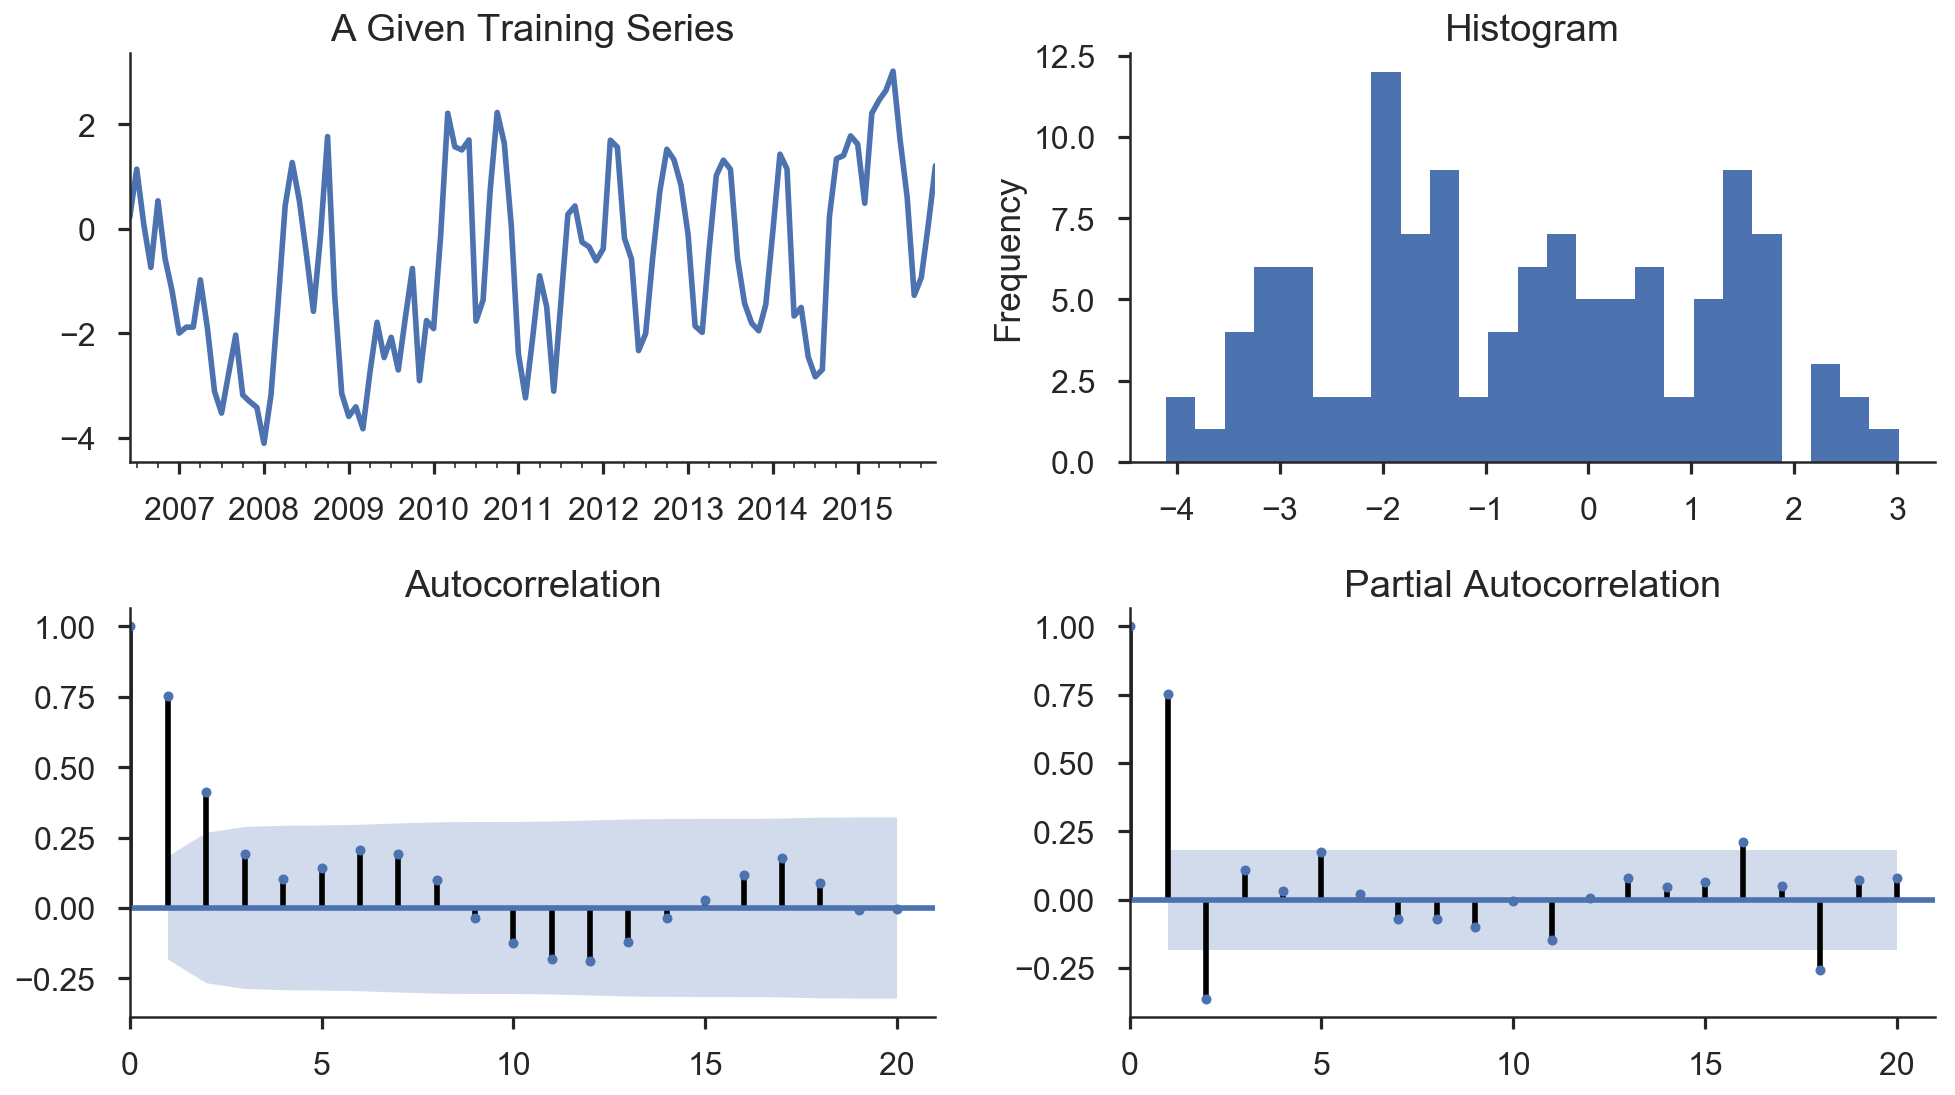

In [11]:
tsplot(ts_train,lags=20,title='A Given Training Series')

In [12]:
# Model Estimation 
# Fit the model 
arima200=sm.tsa.SARIMAX(ts_train,order=(2,0,0))
model_results=arima200.fit()

In [29]:
import itertools
p_min=0
d_min=0
q_min=0
p_max=4
d_max=0
q_max=4
# Initialize a DataFrame to store the results
results_bic=pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],columns=['MA{}'.format(i) for i in range(q_min,q_max+1)]) 

for p,d,q in itertools.product(range(p_min,p_max+1),
                              range(d_min,d_max+1),
                              range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p),'MA{}'.format(q)]=np.nan 
        continue
    try:
        model=sm.tsa.SARIMAX(ts_train,order=(p,d,q))
        results=model.fit()
        results_bic.loc['AR{}'.format(p),'MA{}'.format(q)]=results.bic 
    except:
        continue
results_bic=results_bic[results_bic.columns].astype(float) 


/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/tools/numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

In [30]:
results_bic

,MA0,MA1,MA2,MA3,MA4
AR0,nan,nan,nan,nan,nan
AR1,367.53622,355.40161,360.08554,364.06009,366.35717
AR2,357.60469,360.06480,nan,367.28392,370.51166
AR3,360.00896,364.68589,nan,360.65908,372.72983
AR4,364.37604,369.19912,nan,364.28501,372.66770


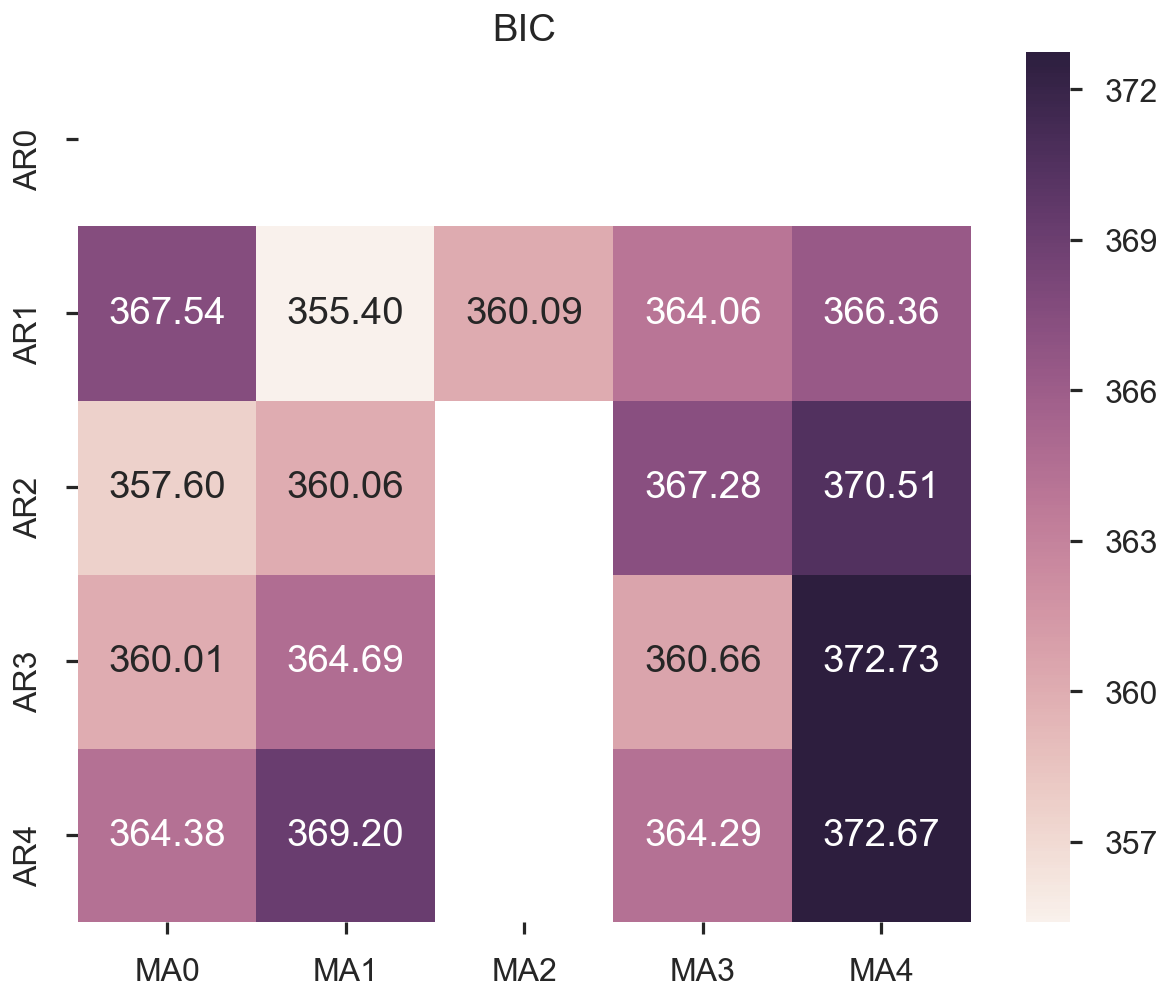

In [31]:
fig,ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(results_bic,mask=results_bic.isnull(),ax=ax,annot=True,fmt='.2f',)
ax.set_title('BIC')

In [32]:
train_results=sm.tsa.arma_order_select_ic(ts_train,ic=['aic','bic'],trend='nc',max_ar=4,max_ma=4)

/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/nanji/miniconda3/envs/py35/lib/python3.5/site-packages/scipy/signal/signaltools.py:1360: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in 

In [33]:
print('AIC',train_results.aic_min_order)

AIC (4, 2)


In [34]:
print('BIC',train_results.bic_min_order)

BIC (1, 1)


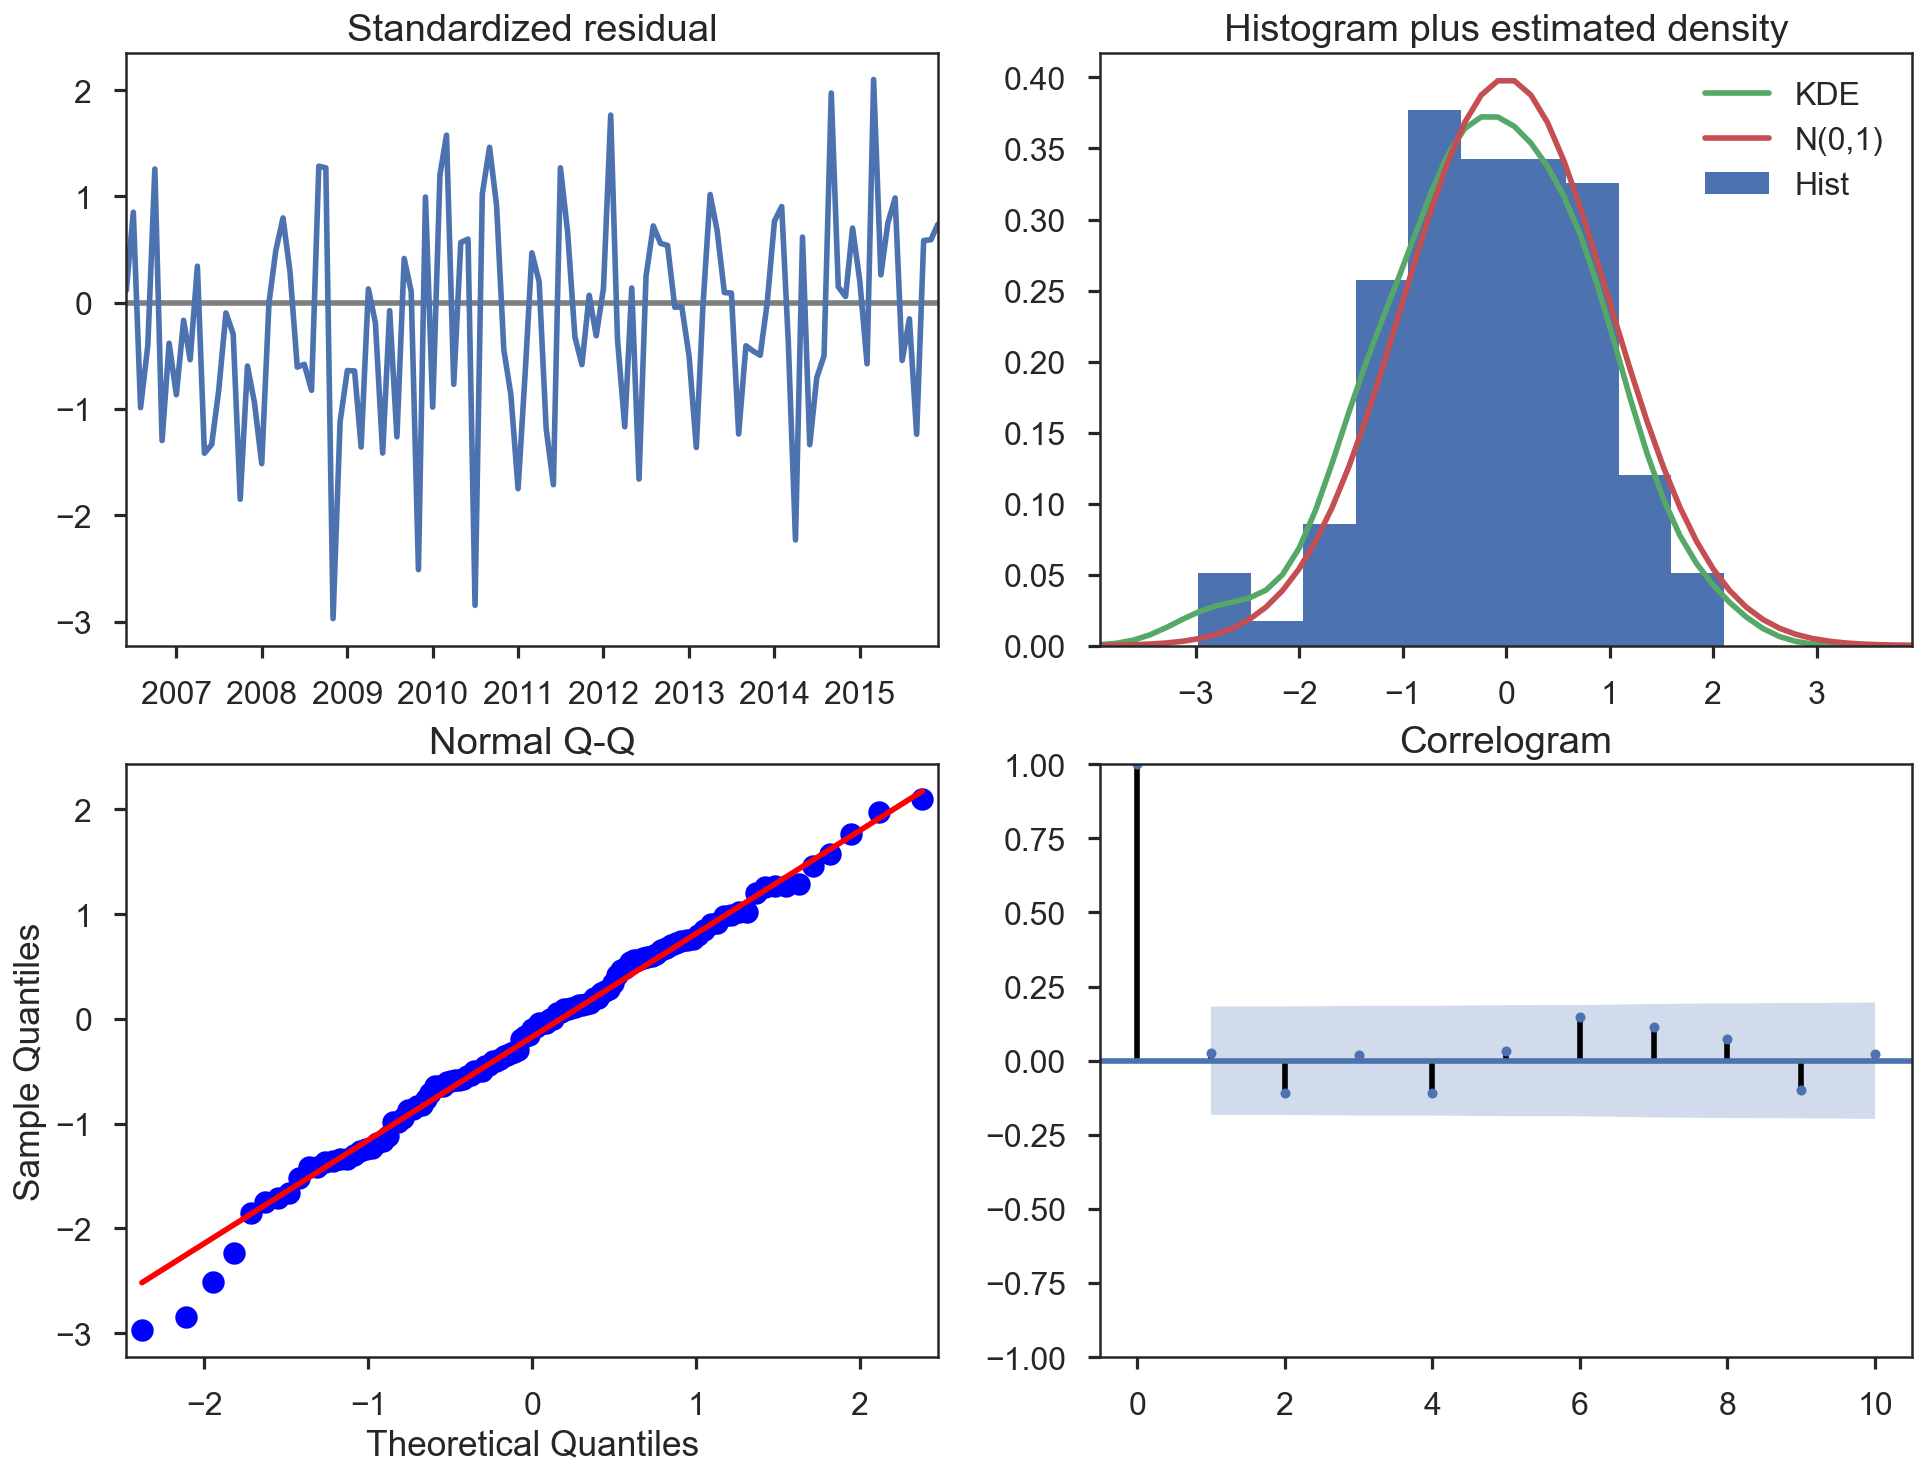

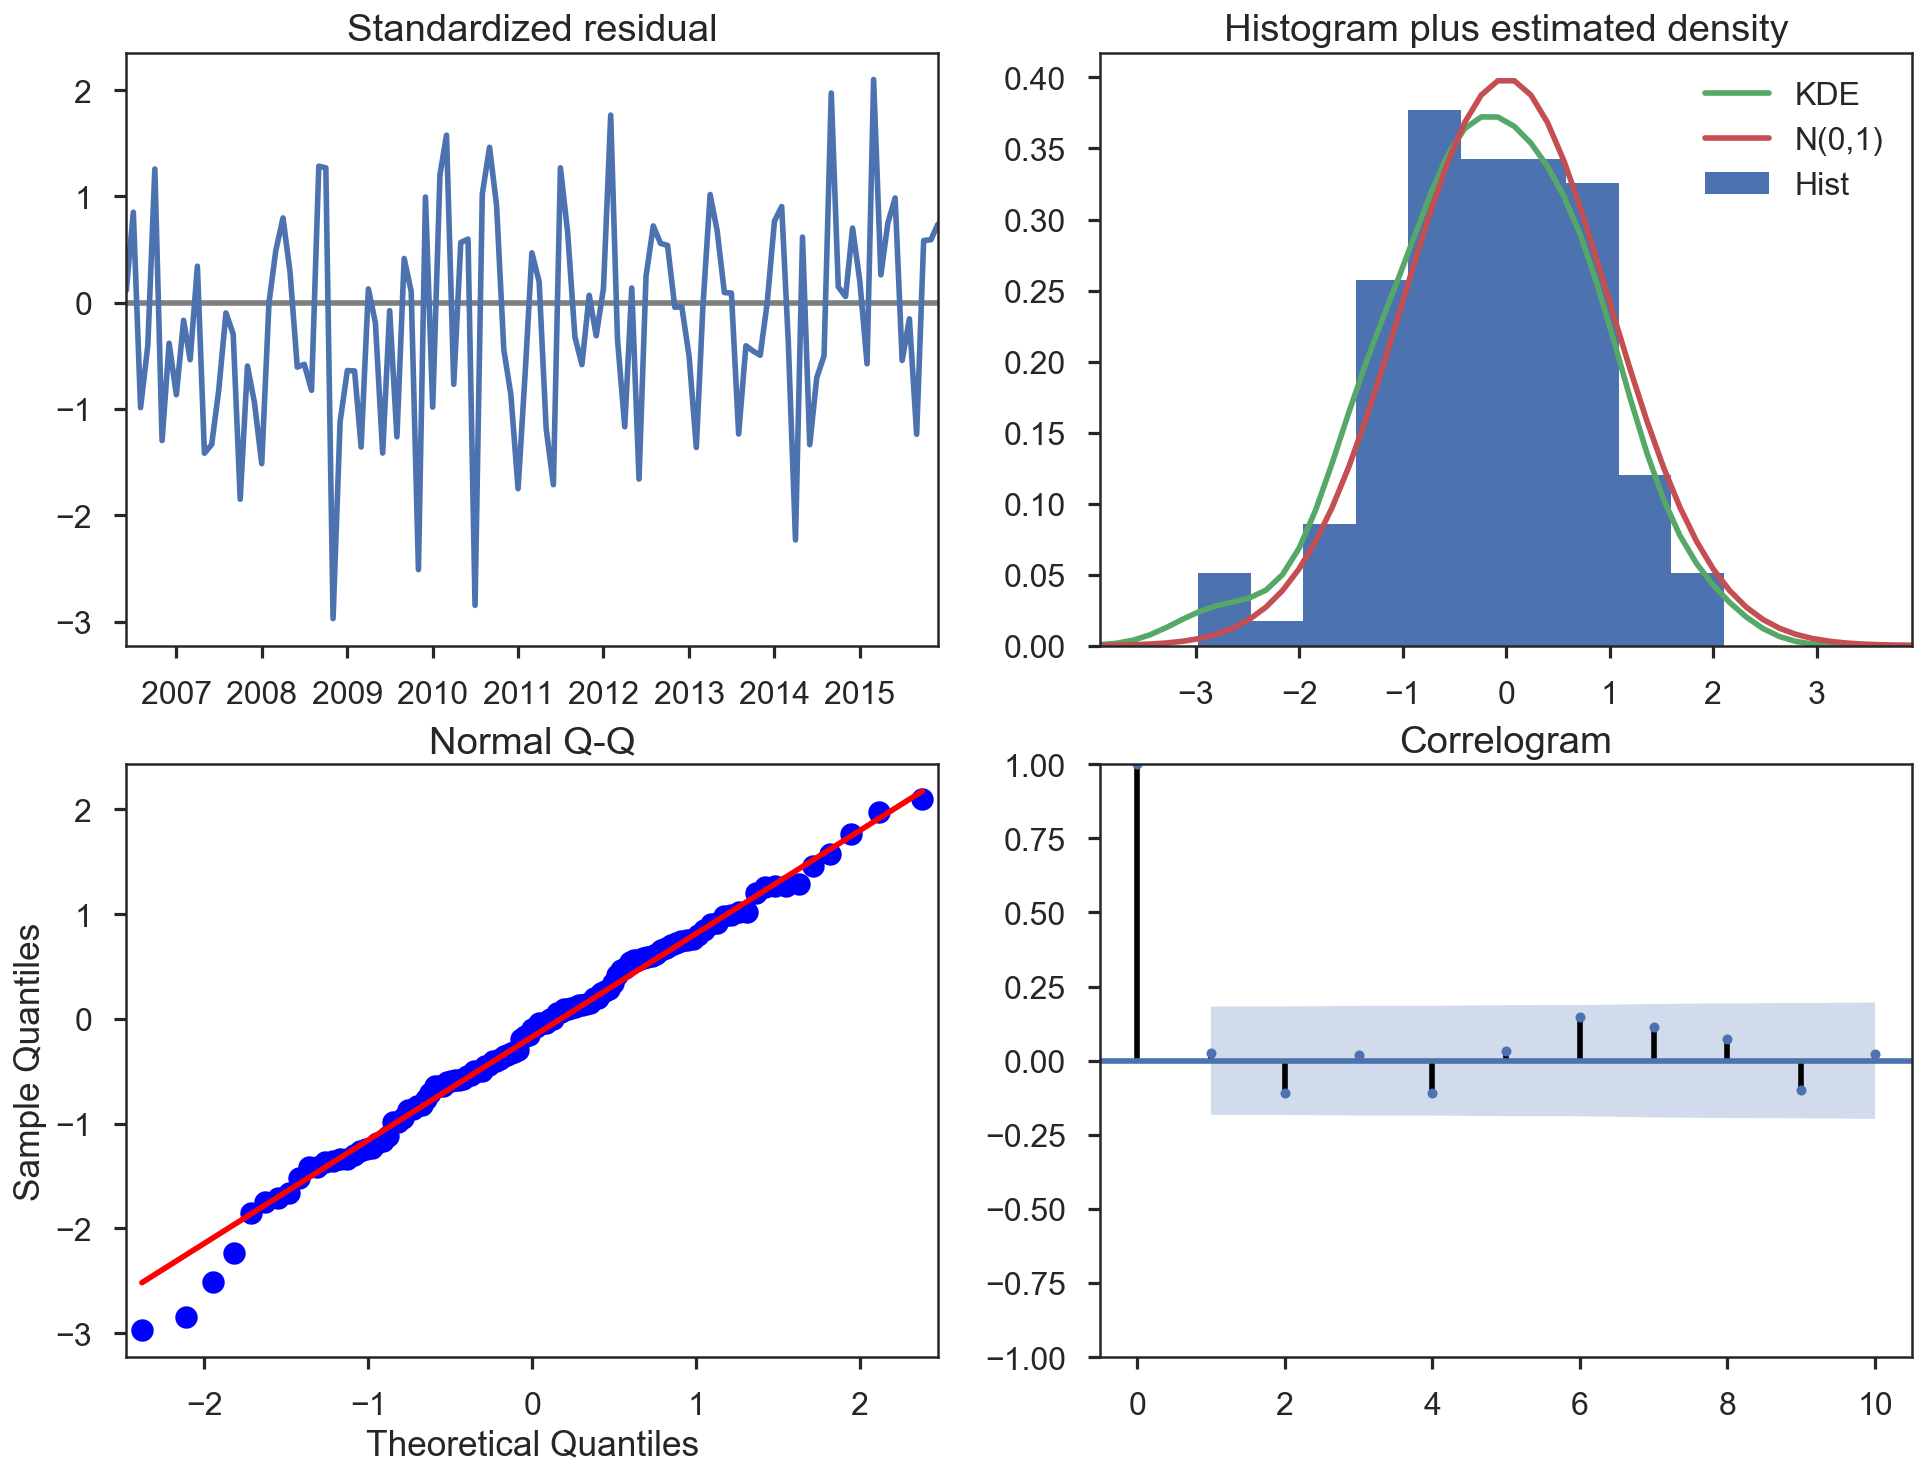

In [35]:
# 残差分析 正态分布 QQ图线性 
model_results.plot_diagnostics(figsize=(16,12))